In [1]:
import pandas as pd
import numpy as np
import math
# Import libraryu for load file pkl and txt
import pickle  
import json 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import plotly.express as px

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.metrics import Precision

from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback


In [2]:
df = pd.read_csv('ho.csv', sep=';')

In [3]:
df

,Kalimat,kata,pos,tag
0,Kalimat 1,forza,NaN,B-Game
1,Kalimat 1,horizon,NaN,E-Game
2,Kalimat 1,5,NaN,O
3,Kalimat 1,om,NaN,O
4,Kalimat 1,install,NaN,O
...,...,...,...,...
4783,Kalimat 901,install,NaN,O
4784,Kalimat 901,windows,NaN,B-Spek
4785,Kalimat 902,baru,NaN,O
4786,Kalimat 902,bekas,NaN,O


In [4]:
df = df[df['tag'] != 'O']
df = df[['Kalimat','kata','tag']]

In [5]:
df.dropna(inplace=True)

In [6]:
print("Unique words in corpus:", df['kata'].nunique())
print("Unique tags in corpus:", df['tag'].nunique())

words = list(set(df["kata"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(df["tag"].values))
num_tags = len(tags)

Unique words in corpus: 643
Unique tags in corpus: 49


In [7]:
# Class to get sentences
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s: [(w, t) for w, t in zip(s['kata'].values.tolist(),
                                                s['tag'].values.tolist())]
        self.grouped = self.df.groupby("Kalimat").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            s = self.grouped['Kalimat: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s
        except KeyError:
            return None

# Displaying one full sentence
getter = sentence(df)
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]

C:\Users\Richard E.V\AppData\Local\Temp\ipykernel_14928\1759589013.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.df.groupby("Kalimat").apply(agg)


In [8]:
sentences = getter.sentences

In [9]:
sentences[1]

[('jakarta', 'B-Tempat'),
 ('timur', 'E-Tempat'),
 ('packing', 'B-Pengiriman'),
 ('kayu', 'E-Pengiriman')]

In [10]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
import json
with open('wordDict.json', 'w') as fp:
    json.dump(word2idx, fp)

In [12]:
import json
with open('tagDict.json', 'w') as fp:
    json.dump(tag2idx, fp)

In [13]:
max_len = 40

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post")

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [15]:
# Define the embedding dimension
embedding_dim = 50  # This is an example value; choose based on your needs

model = keras.Sequential()
model.add(InputLayer((max_len,)))
model.add(Embedding(input_dim=num_words+1, output_dim=embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

model.summary()


c:\Users\Richard E.V\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 50)         │        32,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 40, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 40, 200)        │       120,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,050 (597.85 KB)

 Trainable params: 153,050 (597.85 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [17]:
batch_size = 20
epochs = 8

In [18]:
history = model.fit(x_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1)

Epoch 1/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.7996 - loss: 2.6800 - val_accuracy: 0.9523 - val_loss: 0.4164
Epoch 2/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9537 - loss: 0.3724 - val_accuracy: 0.9640 - val_loss: 0.3142
Epoch 3/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9660 - loss: 0.2900 - val_accuracy: 0.9678 - val_loss: 0.2792
Epoch 4/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9706 - loss: 0.2298 - val_accuracy: 0.9739 - val_loss: 0.2509
Epoch 5/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9737 - loss: 0.2238 - val_accuracy: 0.9742 - val_loss: 0.2330
Epoch 6/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9768 - loss: 0.1855 - val_accuracy: 0.9758 - val_loss: 0.2065
Epoch 7/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9751 - loss: 0.1836 - val_accuracy: 0.9727 - val_loss: 0.2162
Epoch 8/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9712 - loss: 0.1963 - val_accuracy: 0.9693 - val_loss:

In [28]:
# Evaluation
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step


In [29]:
y_pred.shape

(165, 40)

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

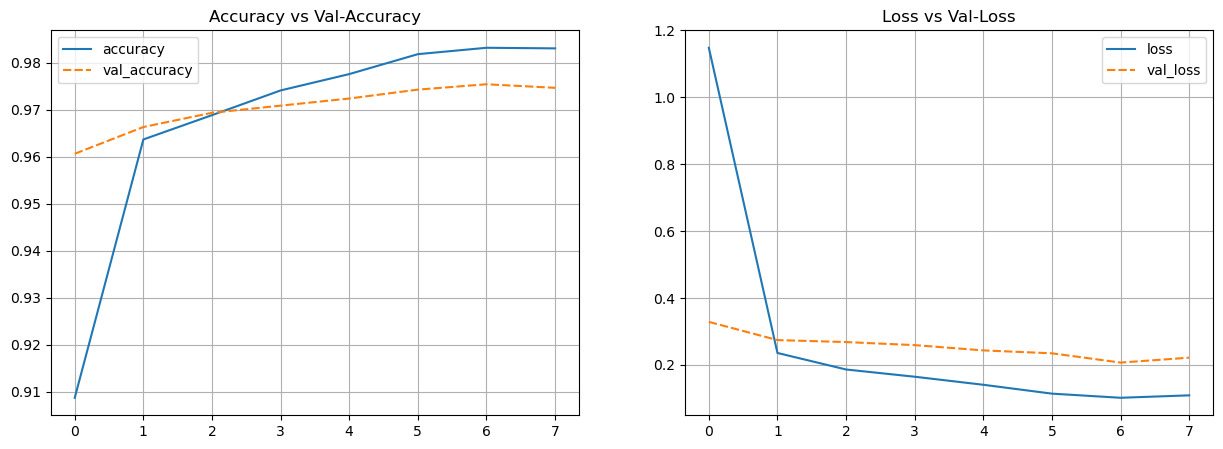

In [31]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### ***Model Save***

In [49]:
import pickle

In [50]:
# Save best model
with open('model_NER.pkl', 'wb') as file1:
  pickle.dump(model, file1)